# TensorFlow 2.0

In [1]:
import os
from glob import glob
from datetime import datetime

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import datasets 

import matplotlib.pyplot as plt

%matplotlib inline

## Hyperparameter Tunning

In [2]:
num_epochs = 20
batch_size = 32

learning_rate = 0.001

dropout_rate = 0.5

input_shape = (32, 32, 3)
num_classes = 10

## Build Model

In [3]:
inputs = layers.Input(input_shape)

net = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

In [4]:
# Model is the full model w/o custom layers
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),  # Optimization
              loss='sparse_categorical_crossentropy',  # Loss Function 
              metrics=['accuracy'])  # Metrics / Accuracy

# Data Preprocess

In [5]:
train_paths = glob('../dataset/cifar/train/*.png')[:1000]
test_paths = glob('../dataset/cifar/test/*.png')[:1000]

In [6]:
def get_class_name(path):
    return path.split('_')[-1].replace('.png', '')

In [7]:
train_labels = [get_class_name(path) for path in train_paths]
class_names = np.unique(train_labels)

In [8]:
def get_label(path):
    fname = tf.strings.split(path, '_')[-1]
    lbl_name = tf.strings.regex_replace(fname, '.png', '')
    onehot = tf.cast(lbl_name == class_names, tf.uint8)
    return tf.argmax(onehot)  # 이번에는 onehot이 아닌 label 번호로

In [9]:
def load_image_label(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    image = tf.cast(image, tf.float32) / 255.  # rescale
    
    label = get_label(path)
    return image, label

In [10]:
# Image Augmentation 수행
def image_preprocess(image, label):
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    return image, label

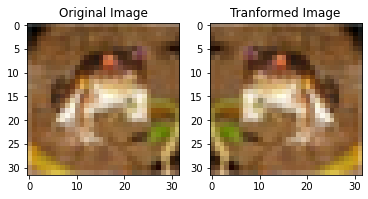

In [11]:
image, label = load_image_label(train_paths[0])
trans_image, label = image_preprocess(image, label)

plt.subplot(121)
plt.title('Original Image')
plt.imshow(image)

plt.subplot(122)
plt.title('Tranformed Image')
plt.imshow(trans_image)
plt.show()

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(image_preprocess, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths))
train_dataset = train_dataset.repeat()

In [14]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.repeat()

# Learning Rate Scheduler

In [15]:
import math

In [16]:
def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.001 * math.exp(0.1 * (10 - epoch))

learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

## Training

http://localhost:6006

In [17]:
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(test_paths) // batch_size

model.fit_generator(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    epochs=num_epochs,
    callbacks=[learning_rate_scheduler]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
31/31 [==============================] - 8s 260ms/step - loss: 2.3109 - accuracy: 0.1126 - val_loss: 2.2958 - val_accuracy: 0.1129
Epoch 2/20
31/31 [==============================] - 8s 257ms/step - loss: 2.2753 - accuracy: 0.1343 - val_loss: 2.2463 - val_accuracy: 0.1300
Epoch 3/20
31/31 [==============================] - 8s 258ms/step - loss: 2.1856 - accuracy: 0.1901 - val_loss: 2.1129 - val_accuracy: 0.2429
Epoch 4/20
31/31 [==============================] - 8s 253ms/step - loss: 2.0995 - accuracy: 0.2262 - val_loss: 2.1501 - val_accuracy: 0.1976
Epoch 5/20
31/31 [==============================] - 8s 253ms/step - loss: 2.0980 - accuracy: 0.2056 - val_loss: 1.9779 - val_accuracy: 0.2450
Epoch 6/20
31/31 [==============================] - 8s 261ms/step - loss: 2.0242 - accuracy: 0.2252 - val_loss: 1.8994 - val_accuracy: 0.2802
Epoch 7/20
31/31 [==============================] - 8s 252ms/step - loss

https://www.tensorflow.org/tensorboard/r2/image_summaries#setup